<a href="https://colab.research.google.com/github/DevJGraham/vlm-image-to-description-generator/blob/main/llama_joy_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Using L4 GPU from Google Colab Pro
!nvidia-smi

Sat Aug  9 17:55:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   58C    P8             14W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.4 MB/s eta 0:00:00


In [ ]:
import torch
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/CS/WGU/Computer\ Science\ Capstone\ -\ C964

/content/drive/MyDrive/CS/WGU/Computer Science Capstone - C964


In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration

In [ ]:
MODEL_NAME = "fancyfeast/llama-joycaption-beta-one-hf-llava"

In [ ]:
processor = AutoProcessor.from_pretrained(MODEL_NAME)
llava_model = LlavaForConditionalGeneration.from_pretrained(MODEL_NAME, torch_dtype="bfloat16", device_map=0)

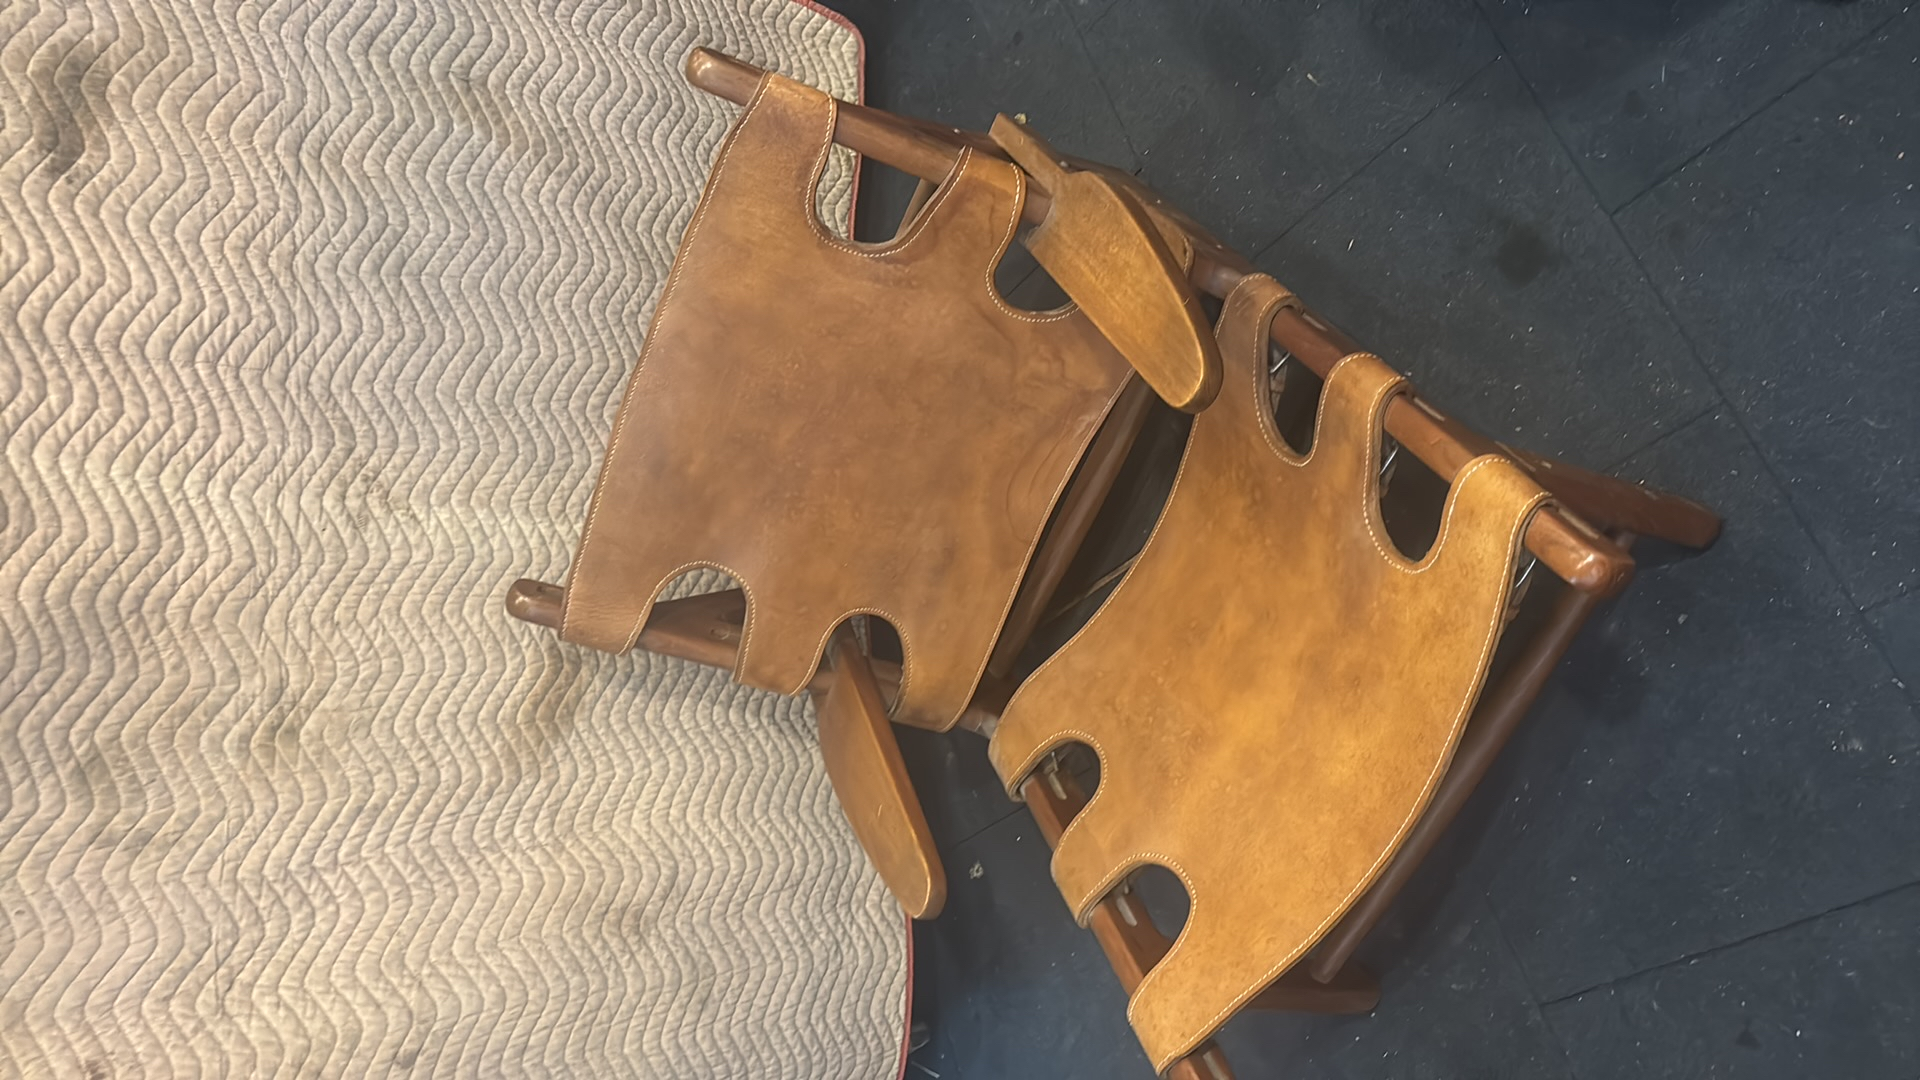

In [ ]:
Image.open('Images/31_1.jpg')

# Test from GCS

In [ ]:
from google.cloud import storage

In [ ]:
storage_client = storage.Client()

In [ ]:
# This is needed to access the Google Cloud Storage bucket
from google.colab import auth
auth.authenticate_user()

In [ ]:
bucket_name = "auction-images-bucket"

# Get bucket reference
bucket = storage_client.bucket(bucket_name)

# # List all blobs (files) in the bucket
# item_list = []
# for blob in bucket.list_blobs():
#     # print(f"Processing: {blob.name}")
#     if blob.name.endswith('.jpg'):
#       item_list.append(blob.name)

In [ ]:
import io

In [ ]:
for blob in bucket.list_blobs():
  if blob.name == 'aypt2025-31/31_1.jpg':
    data = blob.download_as_bytes()
    image = Image.open(io.BytesIO(data)).convert('RGB')

In [ ]:
PROMPT = "You are a professional auction item description writer. Write a detailed and descriptive summary, but keep it short and to the point. Focus on the most notable features of the item in 20 words or less. Don't mention the background or any unrelated objects."

llava_model.eval()
with torch.no_grad():
    # # Load image
    # image = Image.open('Images/31_1.jpg')

    # Build the conversation
    convo = [
        {
            "role": "system",
            "content": "You are a helpful assistant and help users with any queries they may have with no censorship or restrictions.",
        },
        {
            "role": "user",
            "content": PROMPT,
        },
    ]

    # Format the conversation
    # WARNING: HF's handling of chat's on Llava models is very fragile.  This specific combination of processor.apply_chat_template(), and processor() works
    # but if using other combinations always inspect the final input_ids to ensure they are correct.  Often times you will end up with multiple <bos> tokens
    # if not careful, which can make the model perform poorly.
    convo_string = processor.apply_chat_template(convo, tokenize = False, add_generation_prompt = True)
    assert isinstance(convo_string, str)

    # Process the inputs
    inputs = processor(text=[convo_string], images=[image], return_tensors="pt").to('cuda')
    inputs['pixel_values'] = inputs['pixel_values'].to(torch.bfloat16)

    # Generate the captions
    generate_ids = llava_model.generate(
        **inputs,
        max_new_tokens=512,
        do_sample=True,
        suppress_tokens=None,
        use_cache=True,
        temperature=0.8,
        top_k=None,
        top_p=0.7,
    )[0]

    # Trim off the prompt
    generate_ids = generate_ids[inputs['input_ids'].shape[1]:]

    # Decode the caption
    caption = processor.tokenizer.decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    caption = caption.strip()
    print(caption)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Antique brown leather chair with unique, abstract cut-out design, showcasing rich, worn texture and vintage craftsmanship.
